In [202]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 
from statistics import mean, stdev

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 

# Load TCP Benign and DDoS CIC2023 Flows

In [203]:
# Acquire Data
# Data here has all features
current_path = os.getcwd()

# BENIGN DATA FILES ***************************************
file1='dataset/Benign.csv'
benign = pd.read_csv(file1)
benign = benign[(benign['proto_type'] == 6)]
benign['attack'] = 0

# DDOS-VOLUMETRIC ATTACK ***********************************
file2='dataset/TCPFlood.csv'
tcp = pd.read_csv(file2)
tcp['attack'] = 1

# DDOS-TRANSPORT PROTOCOL VULNERABILITIES *******************
file3='dataset/ACKFrag.csv'
file4='dataset/SYN.csv'
file5='dataset/RSTFIN.csv'
file6='dataset/PUSHACK.csv'

ack = pd.read_csv(file3)
syn = pd.read_csv(file4)
rst = pd.read_csv(file5)
psh = pd.read_csv(file6)


ack['attack'] = 1
syn['attack'] = 1
rst['attack'] = 1
psh['attack'] = 1


# DDOS-APPLICATION PROTOCOL VULNERABILITIES *******************
file91='dataset/HTTPFlood.csv'
file92='dataset/Slowloris.csv'
http = pd.read_csv(file91)
slow = pd.read_csv(file92)
http['attack'] = 1
slow['attack'] = 1

## CONCATE ALL THE RECORDS ************************************
frames = [benign, 
          tcp,
          syn, rst, ack, psh, 
          http, slow]

data = pd.concat(frames)

In [204]:
# Size of the data
print("Shape of data: ", data.shape)
# Attack wise size
print("Attack and Benign Records: ", data["attack"].value_counts())

Shape of data:  (309107, 34)
Attack and Benign Records:  attack
1    226482
0     82625
Name: count, dtype: int64


In [205]:
slow.shape

(34426, 33)

In [206]:
data.columns

Index(['ts', 'srcip', 'dstip', 'srcport', 'dstport', 'proto_type', 'sbytes',
       'dbytes', 'flow_bytes', 'rate', 'srate', 'drate', 'spkts', 'dpkts',
       'ttl', 'iat', 'max_iat', 'min_iat', 'total_duration',
       'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len', 'state_con',
       'state_int', 'state_rst', 'fin_flag_number', 'syn_flag_number',
       'psh_flag_number', 'ack_flag_number', 'urg_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'attack', 'x'],
      dtype='object')

# Select parameters based on the model i.e. with or without time based features

In [207]:
# Features according to Importance
features =  [
             'flow_bytes', 'spkts','dpkts','ttl','min_iat',
             'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len',
             #'state_con', 
             'state_rst',
             'fin_flag_number', 'syn_flag_number',
             'psh_flag_number', 'ack_flag_number', 
             #'urg_flag_number'
             #'ece_flag_number', 
             #'cwr_flag_number'
            ]
best_features = data[features] 
target_features = data[['attack']]

## Descriptio of the parametes

**(1) N_IN_Conn_P_Src_IP**: number of packets sent from a source ip address (note src_ip_bytes is similar to it)
**(2) N_IN_Conn_P_Dst_IP**: number of incoming packets to a destination ip address
**(3) spkts**: number of packets transmitted by a source in a flow till now
**(4) dpkts**: number of packets transmitted by a destination in a flow till now
**(5) srate**: spkts/duration of flow
**(6) drate**: dpkts/duration of flow
**(7) avg_packet_len**: mean packet length in bytes in either direction of the a flow
**(8) state_con**: if this is a TCP packet and not first packet in the flow, with RESET flag not on
**(9) state_int**: 1, if this is first packet in a UDP flow
**(10) state_rst**: if this is a TCP packet and reset flag is on, this is the thir flag in tcp
**(11-17) Flags of TCP**: FIN, SYN, PUSH, URG, ECE, CWR, ACK

# Split Dataset into X and Y

In [208]:
# Split of  predictors and response variable
X= best_features
y= target_features

# Use StratifiedKFold with K=10

In [209]:
# Create  classifier object.
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=10)  
n_splits = 10
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
accu_stratified = []
conf_matrices = []  # Store confusion matrices
per_class_accuracies = [] 

In [210]:
# Create model with StratifiedKFold   
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    rf.fit(x_train_fold, y_train_fold)
    #accu_stratified.append(rf.score(x_test_fold, y_test_fold))

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_fold,rf.predict(x_test_fold))
    conf_matrices.append(conf_matrix)
    
    # Compute per-class accuracies
    per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    per_class_accuracies.append(per_class_accuracy)

# Convert lists to numpy arrays for easier manipulation
conf_matrices = np.array(conf_matrices)
per_class_accuracies = np.array(per_class_accuracies)


/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_89691/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_89691/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_89691/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train_fold, y_train_fold)
/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_89691/1092353343.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

Accuracy of Attack Records:  [0.92242527 0.96671911 0.98414619 0.9864456  0.95631127 0.9721617
 0.98547567 0.96526265 0.97906076 0.976519  ]

Median Accuracy of Attack Records: 97.43403534253207 %

Standard Deviation of Attack Records: 0.01920730408924386
Accuracy of Benign Records:  [0.95173967 0.93032497 0.92414341 0.91566584 0.9322236  0.92794384
 0.91805378 0.93120805 0.916284   0.92935359]

Median Accuracy of Benign Records: 92.86487119428077 %

Standard Deviation of Benign Records: 0.01054726873273037


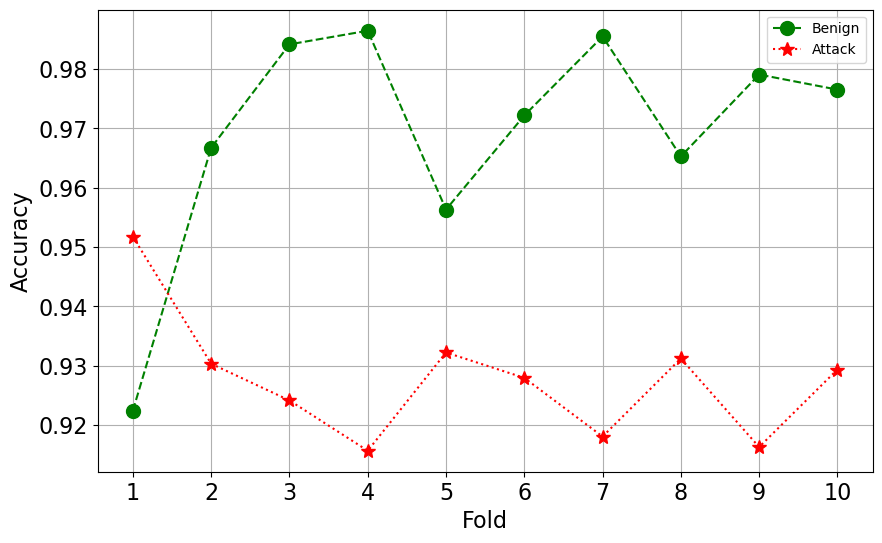

In [211]:
# Plotting per-class accuracies

plt.figure(figsize=(10, 6))
for i, class_accuracy in enumerate(per_class_accuracies.T, 1):
    if(i==1):
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='o', label=f'Benign', color='green',  linestyle='dashed', markersize=10)
        print("Accuracy of Attack Records: ", class_accuracy)
        print('\nMedian Accuracy of Attack Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Attack Records:', stdev(class_accuracy))
    else:
        plt.plot(range(1, n_splits + 1), class_accuracy, marker='*', label=f'Attack', color='red',  linestyle='dotted', markersize=10)  
        print("Accuracy of Benign Records: ", class_accuracy)
        print('\nMedian Accuracy of Benign Records:', np.median(class_accuracy)*100, '%')
        print('\nStandard Deviation of Benign Records:', stdev(class_accuracy))
    
plt.title('')
plt.xlabel('Fold', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(1, n_splits + 1))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.legend()
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('StratifiedKFold_5Tree.png', bbox_inches='tight')
plt.show()

# Training model on the whole dataset

In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(n_estimators = 1, n_jobs=2, random_state=0, max_depth=10)
rf.fit(X, y)

/var/folders/m0/t3_0v49x6v9gdbz4l37dhs580000gn/T/ipykernel_89691/233669711.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X, y)


RandomForestClassifier(max_depth=10, n_estimators=1, n_jobs=2, random_state=0)

# Mean Decrease of Accuracy of the Parameters

[0.01851903186634751, 0.04937117713652238, 0.009369783226247612, 0.009741126067737393, 0.0, 0.03580289477614595, 0.44219382005229974, 0.4314519410062687, 0.0002649589804052171, 8.710593221253003e-05, 0.0, 0.0030224232112378187, 0.00017573774457521342]


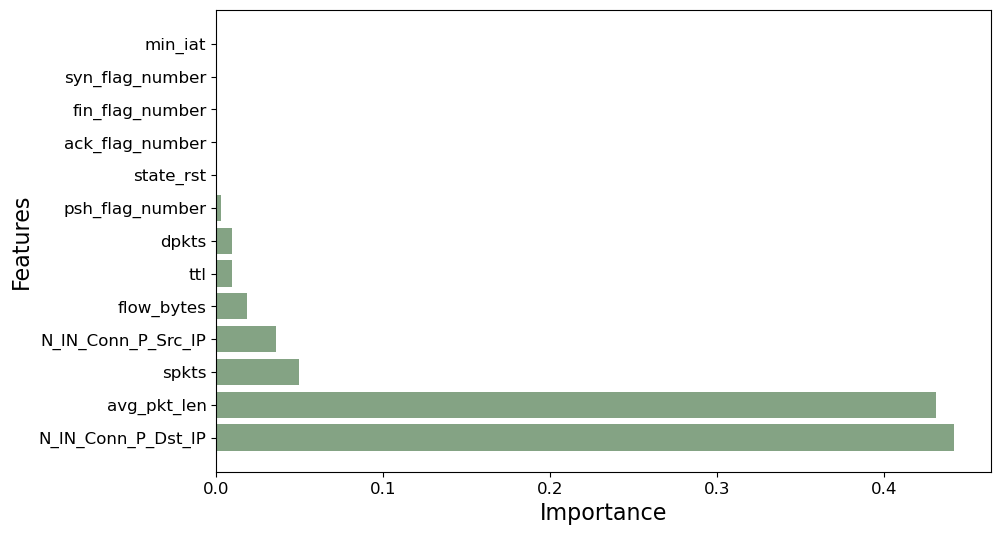

In [213]:
best_features.rename(columns={"N_IN_Conn_P_Src_IP": "N_IN_Conn_Src_IP", "N_IN_Conn_P_Dst_IP": "N_IN_Conn_Dst_IP"})
labels = best_features.columns

importances = list(rf.feature_importances_)
print(importances)
colors = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_list =[importances[i] for i in sorted_indices]
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('')
plt.barh(range(X.shape[1]), sorted_list, align="center",color=colors )
plt.yticks(range(X.shape[1]), labels[sorted_indices], fontsize=12)
plt.xlabel("Importance", fontsize=16)
plt.ylabel("Features", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
# Save the plot as a PNG file
plt.savefig('Importance.png', bbox_inches='tight')
plt.show()

# Generate Tree

In [214]:
from sklearn import tree
from sklearn.tree import export_text
i_tree = 0
for tree_in_forest in rf.estimators_:
    with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
        r = export_text(tree_in_forest)
        print("TREE ", i_tree)
        print(r)  
    i_tree = i_tree + 1

TREE  0
|--- feature_7 <= 64.29
|   |--- feature_7 <= 54.45
|   |   |--- feature_9 <= 0.50
|   |   |   |--- feature_3 <= 122.50
|   |   |   |   |--- feature_6 <= 1.50
|   |   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |   |--- feature_1 <= 1.50
|   |   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_3 <= 44.00
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- feature_3 >  44.00
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 128.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- feature_0 >  128.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- feature_8 >  0.50
|   |   |   |   |   |   |   |   |--- feature_3 <= 61.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- feature_3 >  61.50
|   |   |   |   |   |   |   |   |   |--- feature_12 <= 0.50
|   |   |   |   |  

# Save the RF Attack Detector

In [215]:
import pickle as pickle
filename = 'final_rf_model_dos_tcp.sav'
pickle.dump(rf, open(filename, 'wb'))

# Display (Match-Action) Rules of the RF Tree, acceptable to P4

In [216]:
from io import StringIO
from numbers import Integral

import numpy as np
import pandas
import pickle 
import sklearn
from sklearn import tree 
from sklearn.tree import export_text

from sklearn.tree import _tree

from sklearn.tree import DecisionTreeClassifier

filename = 'final_rf_model_dos_tcp.sav'
rf = pickle.load(open(filename, 'rb'))

i_tree = 0 

global_id = 0

def export_p4(decision_tree):
    tree_ = decision_tree.tree_
    class_names = decision_tree.classes_
    right_child_fmt = "{} {} <= {}\n"
    left_child_fmt = "{} {} >  {}\n"
    truncation_fmt = "{} {}\n"
    feature_names_ = ["{}".format(i) for i in tree_.feature]  
    export_text.report = ""
    max_depth=10
    spacing=3
    decimals=2
    show_weights=False

    if isinstance(decision_tree, DecisionTreeClassifier):
        value_fmt = "{}{} weights: {}\n"
        if not show_weights:
            value_fmt = "{}{}{}\n"
    else:
        value_fmt = "{}{} value: {}\n"

    def _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id):
        global global_id
        global i_tree 
        current_id = global_id

        val = ''
        is_classification = isinstance(decision_tree,
                                       DecisionTreeClassifier)
        if show_weights or not is_classification:
            val = ["{1:.{0}f}, ".format(decimals, v) for v in value]
            val = '['+''.join(val)[:-2]+']'
        if is_classification:
            val += ' class: ' + str(class_name)
        export_text.report += value_fmt.format(indent, '', val)
        #print("table_add MyIngress.level_", i_tree,"_", depth, " ", "MyIngress.SetClass",i_tree," ", previous_id," ",prevfeature," ", result," ", "=>"," ", current_id, " ", int(float(class_name)), sep="")
        print("table_add MyIngress.TCPlevel_", depth, " ", "MyIngress.SetClassTCP"," ", previous_id," ",prevfeature," ", result," ", "=>"," ", current_id, " ", int(float(class_name)), sep="")

    def print_tree_recurse(node, depth, prevfeature, result, previous_id):
        indent = ("|" + (" " * spacing)) * depth
        indent = indent[:-spacing] + "-" * spacing
        global global_id
        global i_tree 
        global_id = global_id + 1
        current_id = global_id

        value = None
        if tree_.n_outputs == 1:
            value = tree_.value[node][0]
        else:
            value = tree_.value[node].T[0]
        class_name = np.argmax(value)

        if (tree_.n_classes[0] != 1 and
                tree_.n_outputs == 1):
            class_name = class_names[class_name]

        if depth <= max_depth+1:
            info_fmt = ""
            info_fmt_left = info_fmt
            info_fmt_right = info_fmt

            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                name = feature_names_[node]
                threshold = tree_.threshold[node]
                threshold = "{1:.{0}f}".format(decimals, threshold)
                export_text.report += right_child_fmt.format(indent,
                                                             name,
                                                             threshold)
                export_text.report += info_fmt_left
                #if int(name) == 9 or int(name) == 11:
                   #print("**********", name, threshold, float(threshold), 1000000.0*float(threshold))
                 #  print("table_add MyIngress.level_", i_tree,"_", depth, " MyIngress.CheckFeature ", previous_id, " ", prevfeature, " ", result, " ", "=>", " ", current_id, " ", name," ", int(1000000.0*float(threshold)), sep='')

                #else:
                #print("table_add MyIngress.level_", i_tree,"_", depth, " MyIngress.CheckFeatureTCP ", previous_id, " ", prevfeature, " ", result, " ", "=>", " ", current_id, " ", name," ", int(float(threshold)), sep='')
                print("table_add MyIngress.TCPlevel_", depth, " MyIngress.CheckFeatureTCP ", previous_id, " ", prevfeature, " ", result, " ", "=>", " ", current_id, " ", name," ", int(float(threshold)), sep='')

                print_tree_recurse(tree_.children_left[node], depth+1, name, 1, current_id)

                export_text.report += left_child_fmt.format(indent,
                                                            name,
                                                            threshold)
                export_text.report += info_fmt_right
           #     print("level", depth, "checkfeature", prevfeature, result, "=>", name, threshold)
 

                print_tree_recurse(tree_.children_right[node], depth+1, name, 0, current_id)
            else:  # leaf
                _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id)
        else:
            subtree_depth = _compute_depth(tree_, node)
            if subtree_depth == 1:
                _add_leaf(value, class_name, indent, prevfeature, result, depth, previous_id)
            else:
                trunc_report = 'truncated branch of depth %d' % subtree_depth
                export_text.report += truncation_fmt.format(indent,
                                                            trunc_report)

    print_tree_recurse(0, 1, 0, 1, global_id)


for tree_in_forest in rf.estimators_:
  #r = export_text(tree_in_forest)
  #print(r)
  global i_tree

  i_tree = i_tree + 1
  export_p4(tree_in_forest)

table_add MyIngress.TCPlevel_1 MyIngress.CheckFeatureTCP 0 0 1 => 1 7 64
table_add MyIngress.TCPlevel_2 MyIngress.CheckFeatureTCP 1 7 1 => 2 7 54
table_add MyIngress.TCPlevel_3 MyIngress.CheckFeatureTCP 2 7 1 => 3 9 0
table_add MyIngress.TCPlevel_4 MyIngress.CheckFeatureTCP 3 9 1 => 4 3 122
table_add MyIngress.TCPlevel_5 MyIngress.CheckFeatureTCP 4 3 1 => 5 6 1
table_add MyIngress.TCPlevel_6 MyIngress.CheckFeatureTCP 5 6 1 => 6 2 1
table_add MyIngress.TCPlevel_7 MyIngress.CheckFeatureTCP 6 2 1 => 7 1 1
table_add MyIngress.TCPlevel_8 MyIngress.CheckFeatureTCP 7 1 1 => 8 8 0
table_add MyIngress.TCPlevel_9 MyIngress.CheckFeatureTCP 8 8 1 => 9 3 44
table_add MyIngress.TCPlevel_10 MyIngress.SetClassTCP 9 3 1 => 10 1
table_add MyIngress.TCPlevel_10 MyIngress.CheckFeatureTCP 9 3 0 => 11 0 128
table_add MyIngress.TCPlevel_11 MyIngress.SetClassTCP 11 0 1 => 12 0
table_add MyIngress.TCPlevel_11 MyIngress.SetClassTCP 11 0 0 => 13 1
table_add MyIngress.TCPlevel_9 MyIngress.CheckFeatureTCP 8 8 0 =>

# Now predicting about separatly processes data

In [217]:
current_path = os.getcwd()

file1='dataset/Benign_Test_1.csv'
benign = pd.read_csv(file1)
file2='dataset/RSTFIN_Test.csv'
rst = pd.read_csv(file2)
file3='dataset/TCPFlood.csv'
tcp = pd.read_csv(file3)
file4='dataset/SYN_Test.csv'
file5='dataset/HTTPFlood_Test.csv'
http = pd.read_csv(file5)
file6='dataset/SlowLoris_Test.csv'
slow = pd.read_csv(file6)
file7='dataset/PUSHACK_Test.csv'
psh = pd.read_csv(file7)
file8='dataset/ACKFrag_Test.csv'
ack = pd.read_csv(file8)

benign = benign[(benign['proto_type'] == 6)]
benign['attack'] = 0
rst['attack'] = 1
tcp['attack'] = 1
syn['attack'] = 1
ack['attack'] = 1
psh['attack'] = 1
http['attack'] = 1
slow['attack'] = 1

In [218]:
data = pd.concat([benign])
print(data.columns)

Index(['ts', 'srcip', 'dstip', 'srcport', 'dstport', 'proto_type', 'sbytes',
       'dbytes', 'flow_bytes', 'rate', 'srate', 'drate', 'spkts', 'dpkts',
       'ttl', 'iat', 'max_iat', 'min_iat', 'total_duration',
       'N_IN_Conn_P_Src_IP', 'N_IN_Conn_P_Dst_IP', 'avg_pkt_len', 'state_con',
       'state_int', 'state_rst', 'fin_flag_number', 'syn_flag_number',
       'psh_flag_number', 'ack_flag_number', 'urg_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'attack'],
      dtype='object')


# Test Benign

In [219]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

data = pd.concat([benign])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:", 1- sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.998998998998999
Precision:  [1. 0.]
Recall:  [0.998999 0.      ]
F1-score:  [0.99949925 0.        ]
Support:  [999   0]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test SYN Flood

In [220]:
data = pd.concat([syn])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9764658598669227
Precision:  [0. 1.]
Recall:  [0.         0.97646586]
F1-score:  [0.         0.98809282]
Support:  [    0 44786]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TCP PUSH ACK

In [221]:
data = pd.concat([psh])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9992763283184155
Precision:  [0. 1.]
Recall:  [0.         0.99927633]
F1-score:  [0.         0.99963803]
Support:  [    0 26255]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TCP ACK Fragmentation

In [222]:
data = pd.concat([ack])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9640035118525022
Precision:  [0. 1.]
Recall:  [0.         0.96400351]
F1-score:  [0.         0.98167188]
Support:  [   0 1139]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test TCP DoS

In [223]:
data = pd.concat([tcp])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.998291939802419
Precision:  [0. 1.]
Recall:  [0.         0.99829194]
F1-score:  [0.         0.99914524]
Support:  [    0 43324]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test RST FIN Flood

In [224]:
data = pd.concat([rst])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy: ", sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy:  0.9957322175732217
Precision:  [0. 1.]
Recall:  [0.         0.99573222]
F1-score:  [0.         0.99786155]
Support:  [    0 11950]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test HTTP Flood

In [225]:
data = pd.concat([http])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.9168842471714534
Precision:  [0. 1.]
Recall:  [0.         0.91688425]
F1-score:  [0.         0.95664018]
Support:  [   0 2298]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test Slowloris

In [226]:
data = pd.concat([slow])
best_features = data[features]
target_features = data[['attack']]
prediction = rf.predict(best_features)
print("Accuracy:",  sum(prediction)/len(prediction))
# Calculate precision, recall, F1-score, and support
precision, recall, fscore, support = precision_recall_fscore_support(target_features, prediction)
# Print the results for each class
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", fscore)
print("Support: ", support)

Accuracy: 0.8771222410865874
Precision:  [0. 1.]
Recall:  [0.         0.87712224]
F1-score:  [0.         0.93453929]
Support:  [   0 4712]


/Users/mahrukh/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
